# Partie amélioration ancien jeux

## Libs et fonctions utiles

In [158]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [159]:
def affichage(image,palette='gray',titre=None,taille=10,show=True):
    plt.figure(figsize=(taille,taille))
    plt.title(titre)
    #laPalette
    plt.imshow(image,palette)
    if show:
        plt.show()

In [160]:
array2x = []
array4x = []
array8x = []

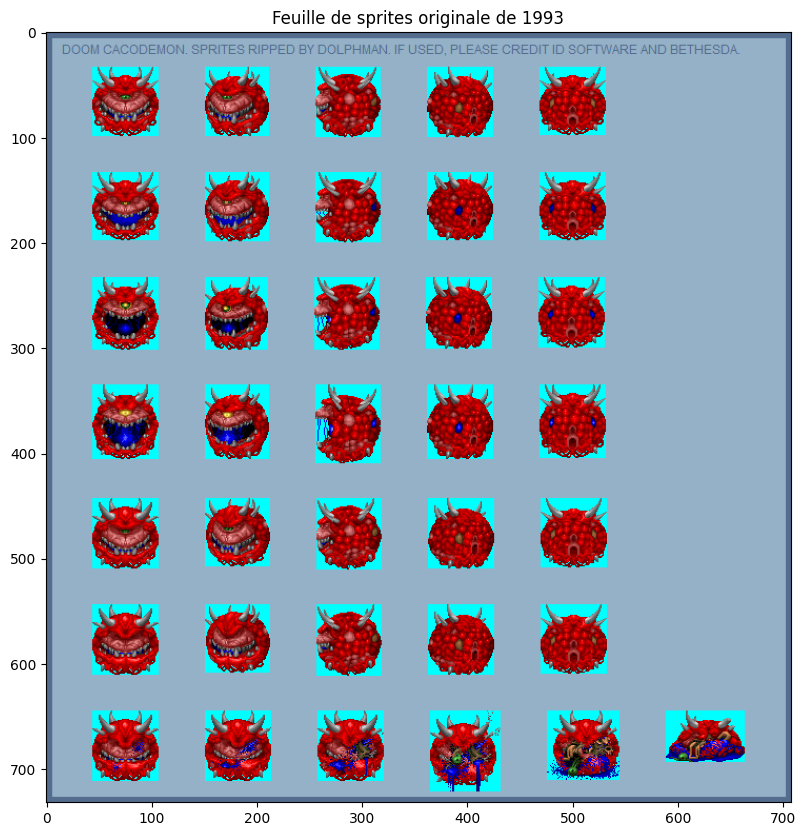

In [161]:
cacoSprites = cv2.imread("./pixel_upscaling/sprites.png",1)
cacoSprites = cv2.cvtColor(cacoSprites, cv2.COLOR_BGR2RGB)
affichage(cacoSprites,"jet",titre="Feuille de sprites originale de 1993")

On sélectionne un sprite

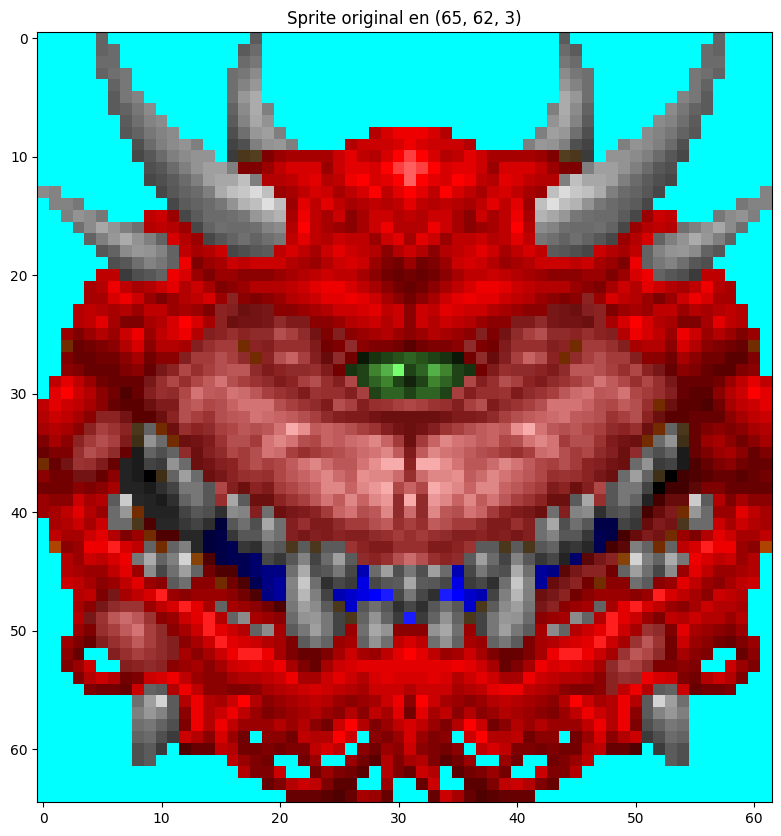

In [162]:
caco = cacoSprites[33:98,44:106]
affichage(caco,"jet",titre="Sprite original en {}".format(caco.shape))

In [163]:
#Nearest neighbour interpolation à la main

def nearest_pixel(image,multi):
    R,G,B = 0,1,2
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    nh,nw = h*multi,w*multi
    
    nimage = np.zeros([nh,nw,rgb])
    
    step = multi
    
    for i in range(h):
        ni = i*multi
        for j in range(w):
            nj = j*multi
            nimage[ni:ni+step,nj:nj+step,R] = image[i,j,R]
            nimage[ni:ni+step,nj:nj+step,G] = image[i,j,G]
            nimage[ni:ni+step,nj:nj+step,B] = image[i,j,B]
    
    return(nimage.astype("int"))
    

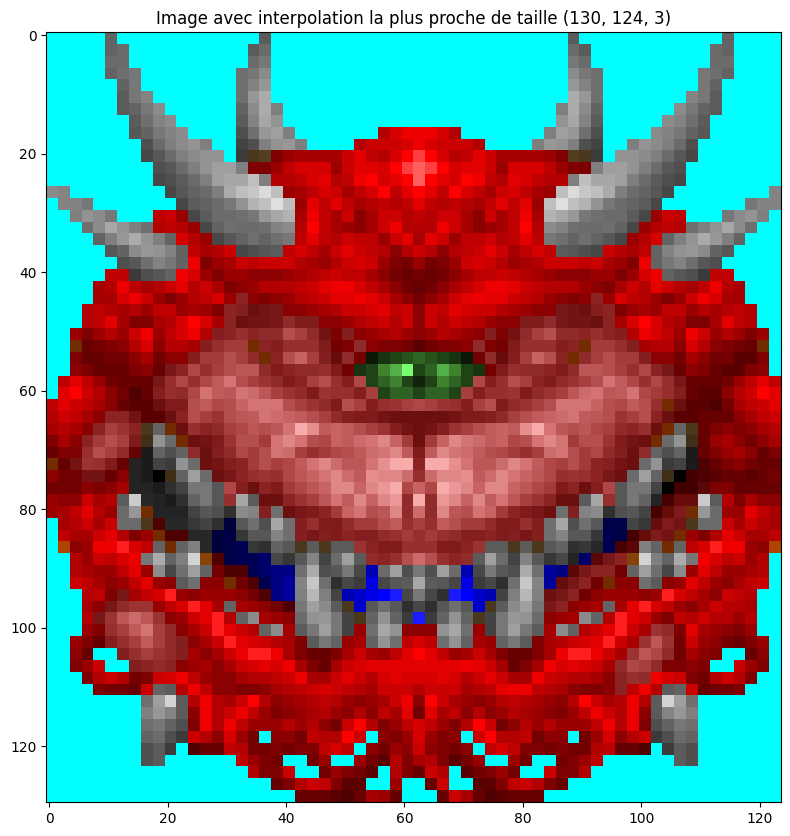

In [164]:
multiplicateur = 2
caco_nearest2x = nearest_pixel(caco,multiplicateur)
array2x.append(caco_nearest2x)
affichage(caco_nearest2x,"jet",titre="Image avec interpolation la plus proche de taille {}".format(caco_nearest2x.shape))

Ici, la fonction consiste seulement à multiplier les pixels par un facteur. L'image à l'air d'être la même mais un pixel  visuel est en fait constitué de plusieurs pixels de la même couleur.

In [165]:
#Ici on interpole en x4 et x8 pour comparer dans la galerie.
caco_nearest4x = nearest_pixel(caco,4)
array4x.append(caco_nearest4x)

caco_nearest8x = nearest_pixel(caco,8)
array8x.append(caco_nearest8x)

In [166]:
# Interpolation bilinéraire avec gestion des bords N&B, fonction de Raphaël
def interpolation_a_la_main_v2_NB(image, facteur):
    n,p = image.shape
    image_upscaled = np.zeros((facteur*n,facteur*p))
    
    # On écarte les pixels connus
    for i in range(n):
        for j in range(p):
            image_upscaled[facteur*i,facteur*j] = image[i,j]

    # On déduis les pixels restants 
    for i in range(n):
        for j in range(p):
            for k in range(1,facteur):
                if (i*facteur+k <= (n-1)*facteur):
                    image_upscaled[i*facteur+k,j*facteur] = np.round((facteur-k)/facteur*image[i,j] + k/facteur*image[i+1,j])
                if (j*facteur+k <= (p-1)*facteur):
                    image_upscaled[i*facteur,j*facteur+k] = np.round((facteur-k)/facteur*image[i,j] + k/facteur*image[i,j+1])
                if (i*facteur+k <= (n-1)*facteur) and (j*facteur+k <= (p-1)*facteur):
                    for m in range(1,facteur):
                        image_upscaled[i*facteur+k,j*facteur+m] = np.round((facteur-k)/facteur*(facteur-m)/facteur*image[i,j]\
                                                                       +k/facteur*(facteur-m)/facteur*image[i+1,j]\
                                                                       +m/facteur*(facteur-k)/facteur*image[i,j+1]\
                                                                       +k/facteur*m/facteur*image[i+1,j+1])
    
    # On complète les bords
    for k in range(1,facteur):
        for i in range((n-1)*facteur+1):
            image_upscaled[i, (p-1)*facteur + k] = image_upscaled[i, (p-1)*facteur]
        for j in range((p-1)*facteur+1):
            image_upscaled[(n-1)*facteur + k, j] = image_upscaled[(n-1)*facteur, j]
   
    # On complète les créneaux
    for i in range(facteur-1):
        for j in range(facteur-1):
                image_upscaled[(n-1)*facteur + i, (p-1)*facteur + j] = image_upscaled[(n-1)*facteur, (p-1)*facteur]
                
    return image_upscaled

# Interpolation avec gestion des bords RGB
def interpolation_a_la_main_v2_RGB(img_rgb, facteur):
    res = np.zeros((img_rgb.shape[0]*facteur,img_rgb.shape[1]*facteur,3))
    for couleur in range(3):
        res[:,:,couleur] = interpolation_a_la_main_v2_NB(img_rgb[:,:,couleur],facteur)
    return res.astype(np.int64)

# Interpolation avec gestion des bords généralisée
def interpolation_a_la_main_v2(img, facteur=2):
    if len(img.shape) == 3:
        return interpolation_a_la_main_v2_RGB(img, facteur)
    else:
        return interpolation_a_la_main_v2_NB(img, facteur)

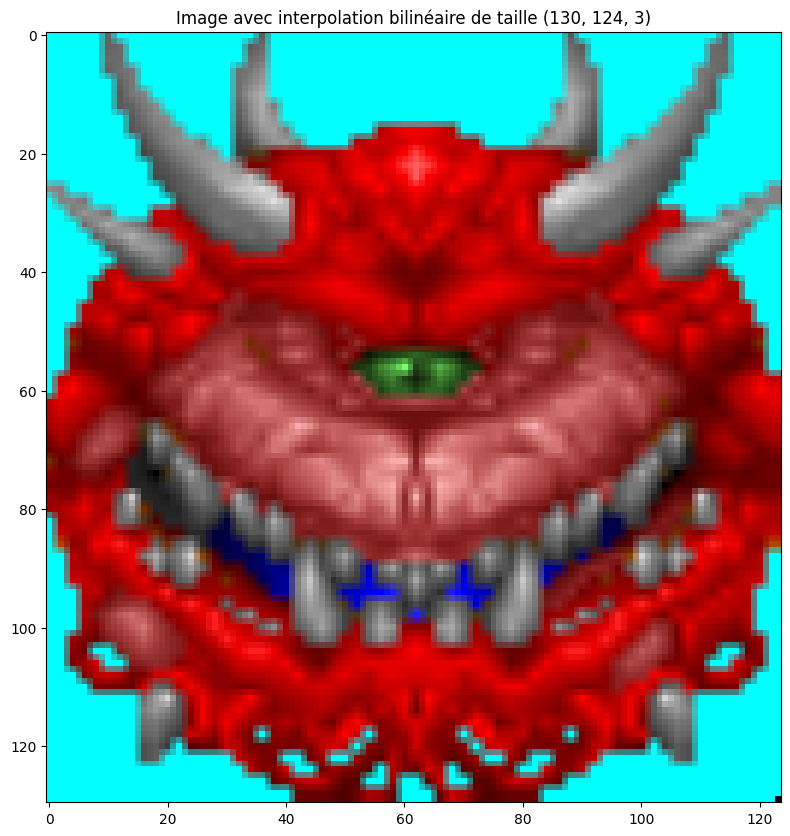

In [167]:
caco_bili2x = interpolation_a_la_main_v2(caco,2)
array2x.append(caco_bili2x) 
affichage(caco_bili2x,"jet",titre="Image avec interpolation bilinéaire de taille {}".format(caco_bili2x.shape))

Taille doublée et rajout de nuances de couleurs ce qui donne un effet de flou. Testons avec différents facteurs.

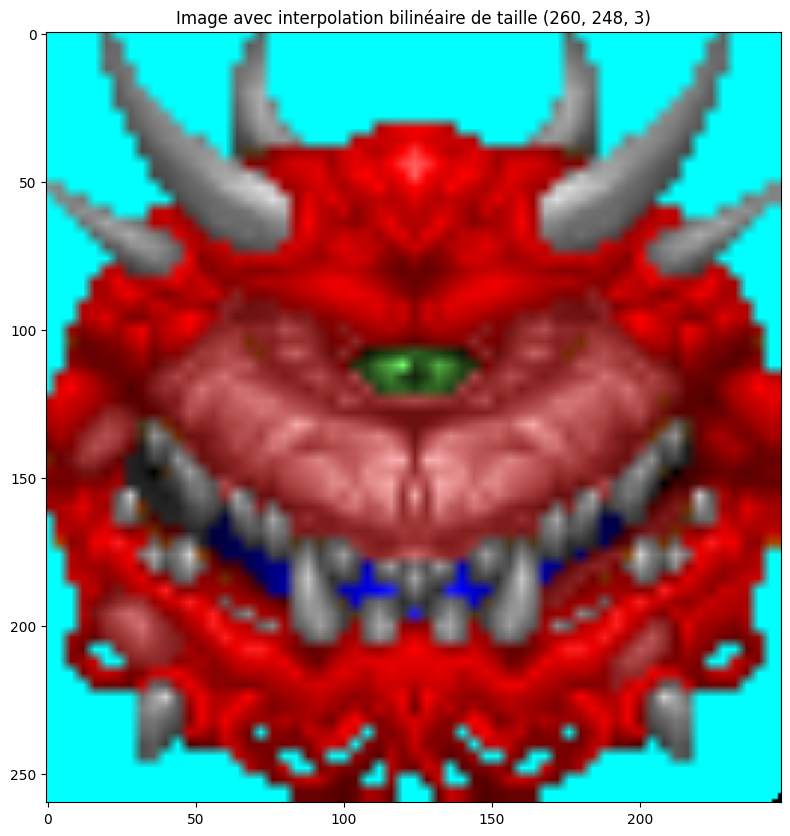

In [168]:
caco_bili4x = interpolation_a_la_main_v2(caco,4)
array4x.append(caco_bili4x) 
affichage(caco_bili4x,"jet",titre="Image avec interpolation bilinéaire de taille {}".format(caco_bili4x.shape))

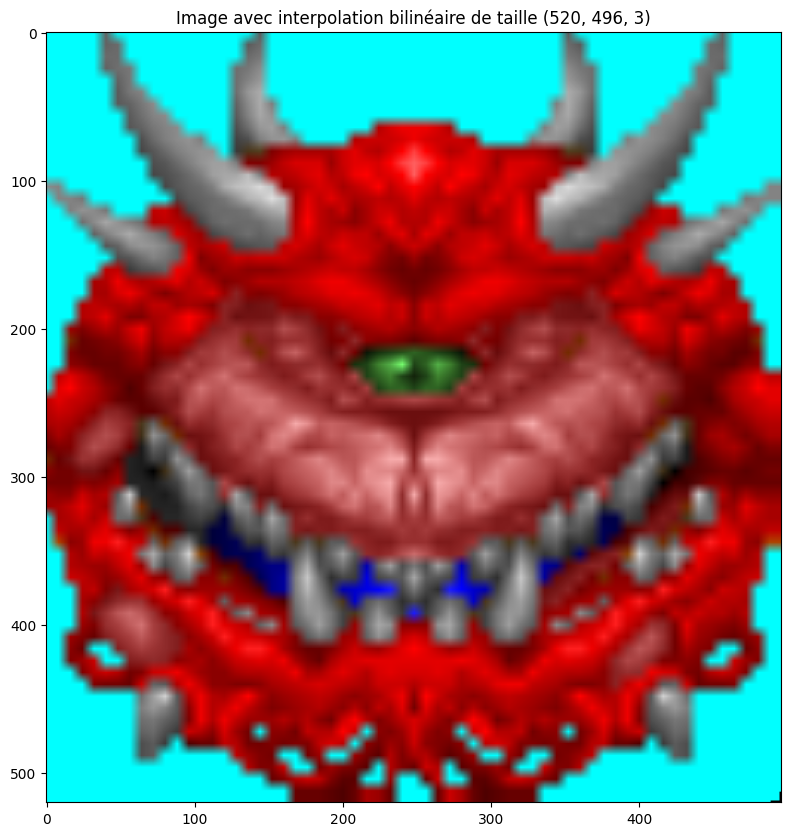

In [169]:
caco_bili8x = interpolation_a_la_main_v2(caco,8)
array8x.append(caco_bili8x) 
affichage(caco_bili8x,"jet",titre="Image avec interpolation bilinéaire de taille {}".format(caco_bili8x.shape))

In [170]:
#Algo 1 EPX/Scale2x/AdvMAME2x 1992 LucasArts

def AdvMAME2x_NB(image,canal):
    
    multi = 2
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    nh,nw = h*2,w*2
    
    image = image[:,:,canal]
    
    nimage = np.zeros([nh,nw])
    
    image = np.pad(image,1)
    
    step = 2
    
    for i in range(0,h):
        ii = i+1
        ni = i*multi
        for j in range(0,w):
            jj = j+1
            nj = j*multi
            
            #init
            P = image[ii,jj]
            
            A = image[ii-1,jj]
            B = image[ii,jj+1]
            C = image[ii,jj-1]
            D = image[ii+1,jj]
            
            
            #Algo Lucasart
            E=P; F=P; G=P; H=P;
            if (C==A and C!=D and A!=B):
                E=A
            if (A==B and A!=C and B!=D):
                F=B
            if (D==C and D!=B and C!=A):
                G=C
            if (B==D and B!=A and D!=C):
                H=D
            
            #Nouvelle val
            
            nimage[ni:ni+step,nj:nj+step] = np.array([[E,F],[G,H]])
            
            
            #correction des bords
            nimage[0,0] = nimage[0,1]
            nimage[0,-1] = nimage[0,-2]
            nimage[-1,0] = nimage[-2,0]
            nimage[-1,-1] = nimage[-2,-2]
    
    return(nimage.astype("int"))

def AdvMAME2x_RGB(image):
    
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    
    nimage = np.zeros([h*2,w*2,rgb])
    
    for canal in range(3):
        nimage[:,:,canal] = AdvMAME2x_NB(image,canal)
        
    return(nimage.astype("int"))

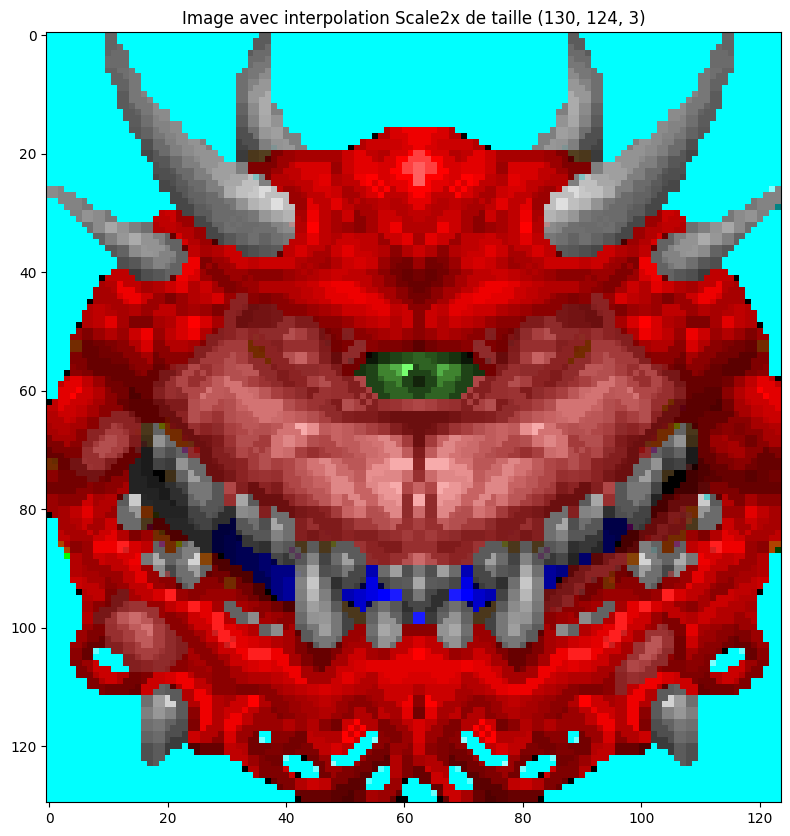

In [171]:
caco_AdvMAME2x = AdvMAME2x_RGB(caco)
array2x.append(caco_AdvMAME2x) 
affichage(caco_AdvMAME2x,"jet",titre="Image avec interpolation Scale2x de taille {}".format(caco_AdvMAME2x.shape))

Quelques carrés noirs au niveau des contours. Ils gagneraient à être plutôt rouge foncé. Ici, c'est la faute du fond cyan qui marque une grande différence de couleur.

In [172]:
#Algo 2 Scale3x/AdvMAME3x
def AdvMAME3x_NB(image,canal):
    
    multi = 3
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    nh,nw = h*multi,w*multi
    
    image = image[:,:,canal]
    
    nimage = np.zeros([nh,nw])
    
    
    image = np.pad(image,1)
    
    step = multi
    
    for i in range(0,h):
        ii = i+1
        ni = i*multi
        for j in range(0,w):
            jj = j+1
            nj = j*multi
            
            #init
            
            A = image[ii-1,jj-1]
            B = image[ii-1,jj]
            C = image[ii-1,jj+1]
            D = image[ii,jj-1]
            E = image[ii,jj]
            F = image[ii,jj+1]
            G = image[ii+1,jj-1]
            H = image[ii+1,jj]
            I = image[ii+1,jj+1]
            
            
            #Algo Lucasart
            c1=E; c2=E; c3=E; c4=E; c5=E; c6=E; c7=E; c8=E; c9=E;
            if( D==B and D!=H and B!=F):
                c1=D
            if( (D==B and D!=H and B!=F and E!=C) or (B==F and B!=D and F!=H and E!=A)):
                c2=B
            if( B==F and B!=D and F!=H):
                c3=F
            if( (H==D and H!=F and D!=B and E!=A) or (D==B and D!=H and B!=F and E!=G)):
                c4=D
            c5=E
            if( (B==F and B!=D and F!=H and E!=I) or (F==H and F!=B and H!=D and E!=C)):
                c6=F
            if( H==D and H!=F and D!=B):
                c7=D
            if( (F==H and F!=B and H!=D and E!=G) or (H==D and H!=F and D!=B and E!=I)):
                c8=H
            if( F==H and F!=B and H!=D):
                c9=F            
            #Nouvelle val
            
            nimage[ni:ni+step,nj:nj+step] = np.array([[c1,c2,c3],[c4,c5,c6],[c7,c8,c9]])
            
            
            
    
    return(nimage.astype("int"))

def AdvMAME3x_RGB(image):
    
    multi = 3
    
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    
    nimage = np.zeros([h*multi,w*multi,rgb])
    
    for canal in range(3):
        nimage[:,:,canal] = AdvMAME3x_NB(image,canal)
        
    return(nimage.astype("int"))

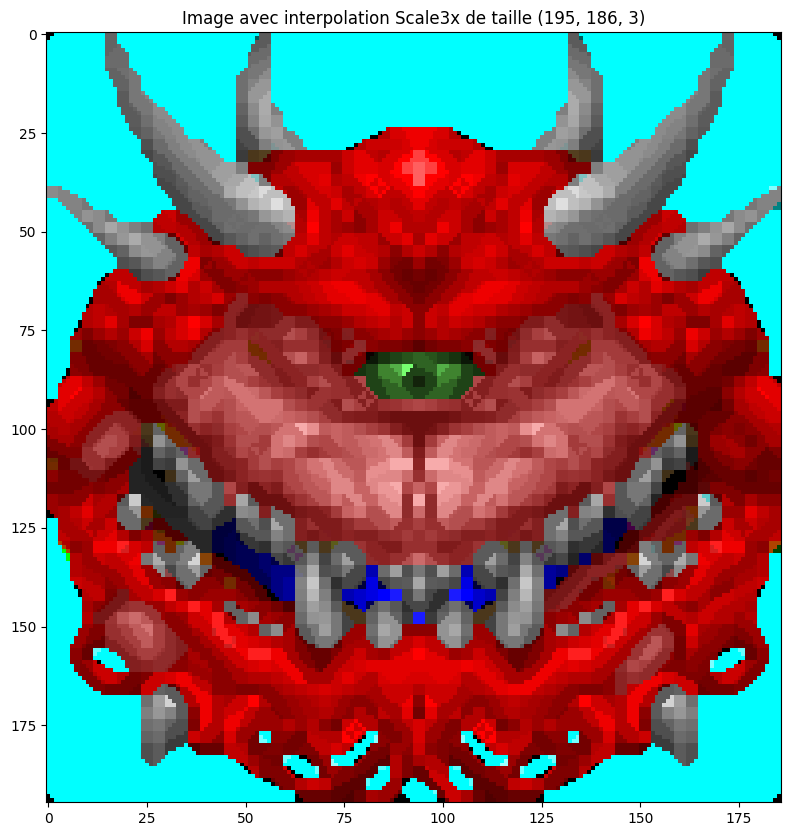

In [173]:
caco_AdvMAME3x = AdvMAME3x_RGB(caco)
affichage(caco_AdvMAME3x,"jet",titre="Image avec interpolation Scale3x de taille {}".format(caco_AdvMAME3x.shape))

Quelques carrés noirs à nouveau qui ne semblent pas très adaptés. De même on a des carrés noirs qui ne nous intéressent pas et qu'il faudrait corriger à la main. Enfin, on remarque qu'il apparait beaucoup plus de formes triangulaires.

In [174]:
#AdvMAME4x
def AdvMAME4x_RGB(image):
    return AdvMAME2x_RGB(AdvMAME2x_RGB(image))

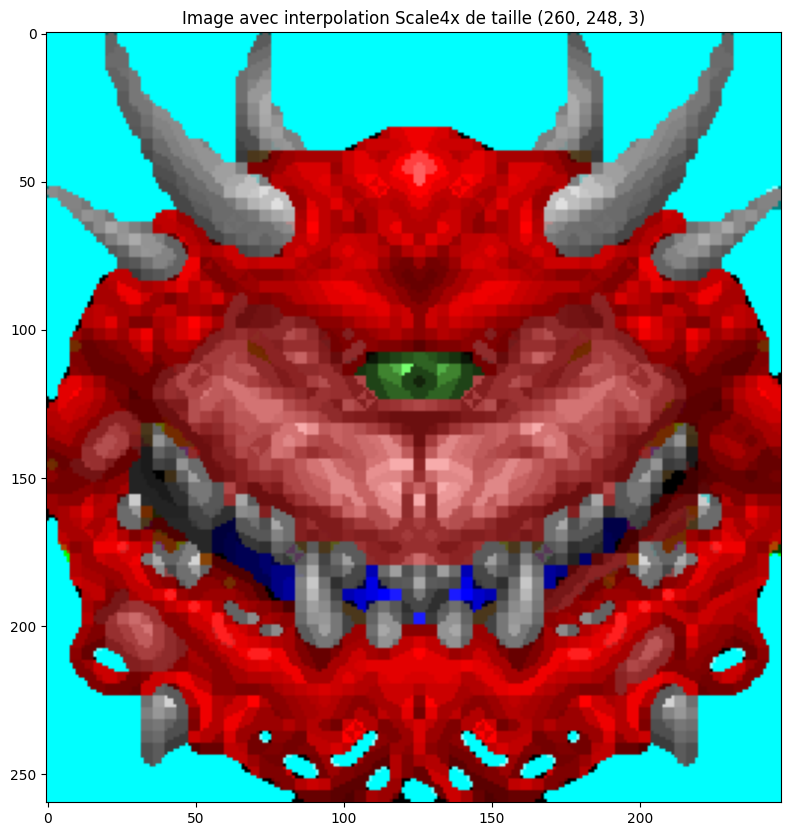

In [175]:
caco_AdvMAME4x = AdvMAME4x_RGB(caco)
array4x.append(caco_AdvMAME4x) 
affichage(caco_AdvMAME4x,"jet",titre="Image avec interpolation Scale4x de taille {}".format(caco_AdvMAME4x.shape))

Toujours le même souci des carrés noirs. Les formes triangulaires un peu brutes se retrouvent légèrement gommées. Ce qui produit un meilleur effet pour l'oeil humain.

In [176]:
#AdvMAME8x pour tester
def AdvMAME8x_RGB(image):
    return AdvMAME4x_RGB(AdvMAME2x_RGB(image))

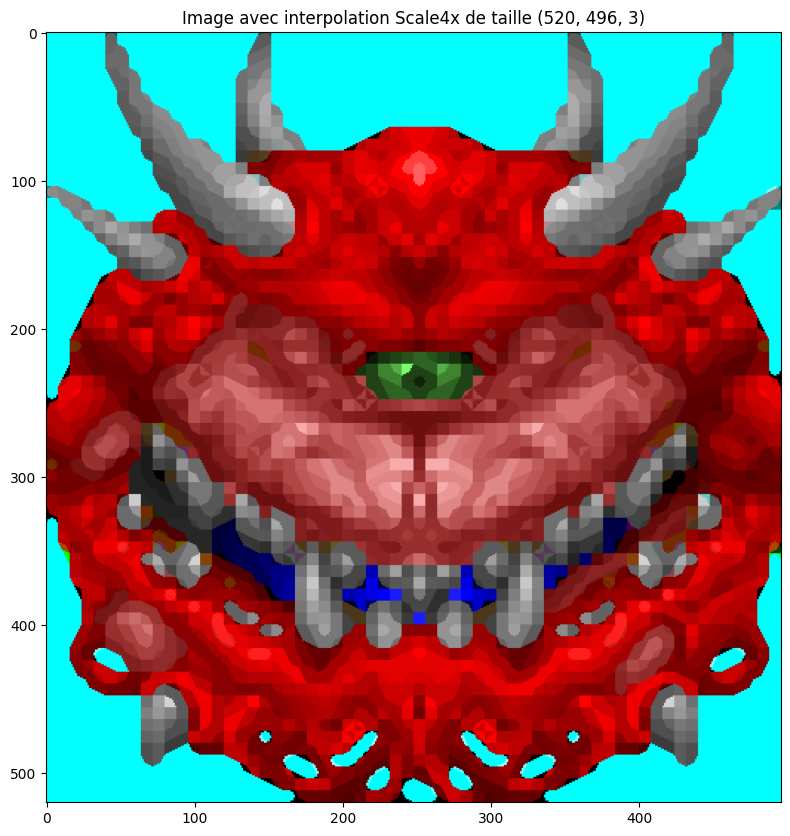

In [177]:
caco_AdvMAME8x = AdvMAME8x_RGB(caco)
array8x.append(caco_AdvMAME8x) 
affichage(caco_AdvMAME8x,"jet",titre="Image avec interpolation Scale4x de taille {}".format(caco_AdvMAME8x.shape))

In [178]:
#Eagle moins bien
def Eagle_NB(image,canal):
    
    multi = 2
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    nh,nw = h*multi,w*multi
    
    image = image[:,:,canal]
    
    nimage = np.zeros([nh,nw])
    
    
    image = np.pad(image,1)
    
    step = multi
    
    for i in range(0,h):
        ii = i+1
        ni = i*multi
        for j in range(0,w):
            jj = j+1
            nj = j*multi
            
            #init
            
            A = image[ii-1,jj-1]
            B = image[ii-1,jj]
            C = image[ii-1,jj+1]
            D = image[ii,jj-1]
            E = image[ii,jj]
            F = image[ii,jj+1]
            G = image[ii+1,jj-1]
            H = image[ii+1,jj]
            I = image[ii+1,jj+1]
            
            
            #Algo Lucasart
            c1=E; c2=E; c3=E; c4=E;
            
            if( D==A==B):
                c1=A
            if( B==C==F):
                c2=C
            if( D==G==H):
                c3=G
            if( F==I==H):
                c4=I            
            #Nouvelle val
            
            nimage[ni:ni+step,nj:nj+step] = np.array([[c1,c2],[c3,c4]])
            
            #correction des bords
            
            #correction des bords
            nimage[0,0] = nimage[0,1]
            nimage[0,-1] = nimage[0,-2]
            nimage[-1,0] = nimage[-2,0]
            nimage[-1,-1] = nimage[-2,-2]
            
    
    return(nimage.astype("int"))

def Eagle(image):
    
    multi = 2
    
    h,w,rgb = image.shape[0],image.shape[1],image.shape[2]
    
    nimage = np.zeros([h*multi,w*multi,rgb])
    
    for canal in range(3):
        nimage[:,:,canal] = Eagle_NB(image,canal)
        
    return(nimage.astype("int"))

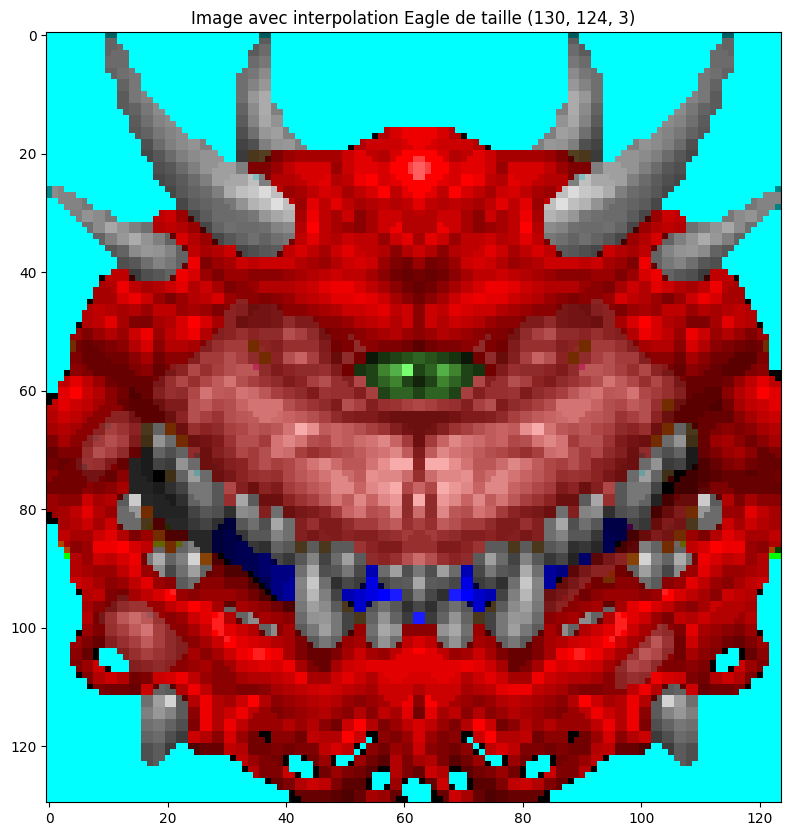

In [179]:
caco_Eagle = Eagle(caco)
array2x.append(caco_Eagle) 
affichage(caco_Eagle,"jet",titre="Image avec interpolation Eagle de taille {}".format(caco_Eagle.shape))

L'algo Eagle n'est pas le plus beau et génère beaucoup de points noirs. Il y a même du vert très clair sur les extrémités horizontales. Comparons avec le Scale2x

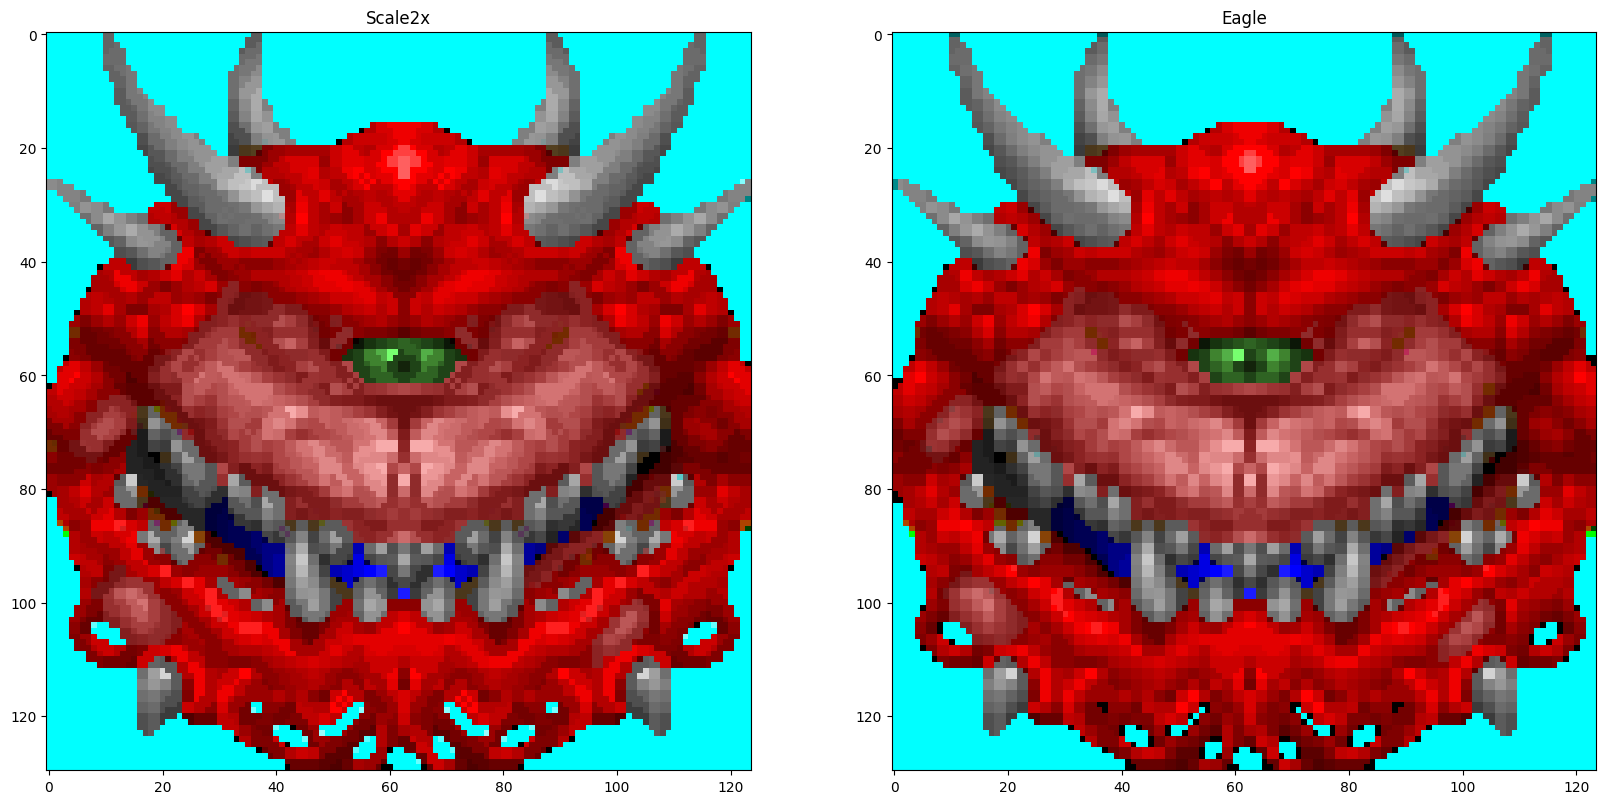

In [180]:
taille = 20
plt.figure(figsize=[taille,taille])
plt.subplot(1,2,1)
plt.title("Scale2x")
plt.imshow(caco_AdvMAME2x)
plt.subplot(1,2,2)
plt.title("Eagle")
plt.imshow(caco_Eagle)
plt.show()

Eagle est un peu plus d'apparence pixélisée et avec des couleurs bizarres plus flagrantes. Eagle ne prend en compte que les pixels à gauche pour choisir la couleur d'un nouveau pixel ce qui n'est pas nécessairement la meilleur idée. La partie droite de l'information est ignorée ce qui est imparfait.

In [181]:
#hqx très difficile à implémenter. 12000 lignes de codes en C. On peut l'optimiser mais c'est très très (trop) long
#http://blog.pkh.me/p/19-butchering-hqx-scaling-filters.html

Pour installer superxbr à partir du dossier py-super-xbr :

'pip install .'

In [182]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

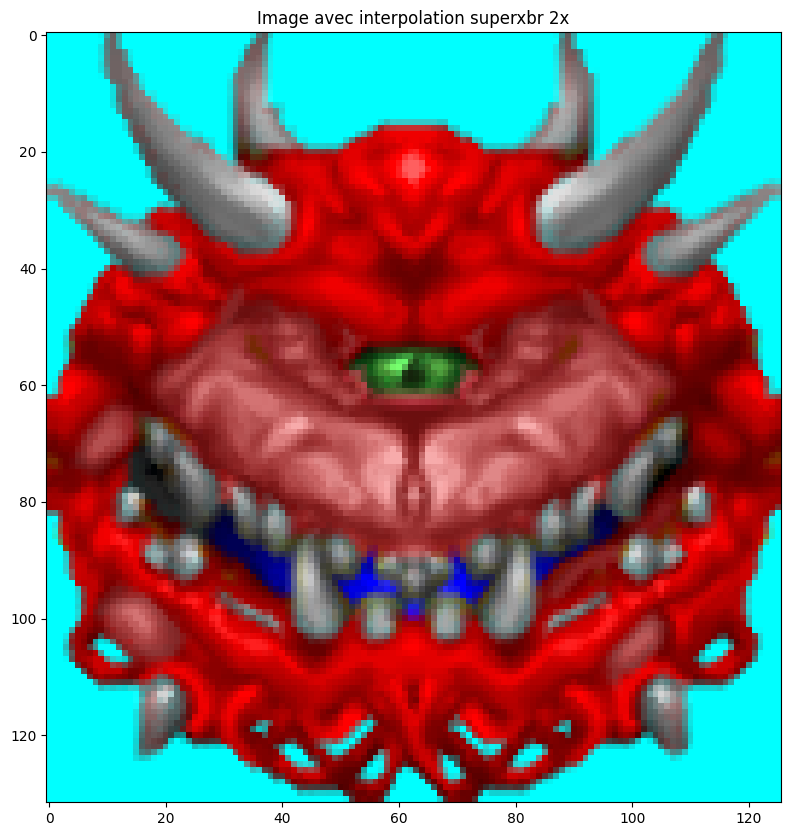

In [183]:
#SuperxBR, compliqué à implémenter, voilà un exemple https://github.com/n0spaces/py-super-xbr
from PIL import Image
from superxbr import superxbr

cacoImage = Image.open("./pixel_upscaling/cacoDecoupe.png")

#Beaucoup de warnings à cause d'une fonction trop ancienne donc on les bloque.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    caco_superxbr2 = superxbr.scale(cacoImage)

array2x.append(caco_superxbr2)
affichage(caco_superxbr2,"jet",titre="Image avec interpolation superxbr 2x")

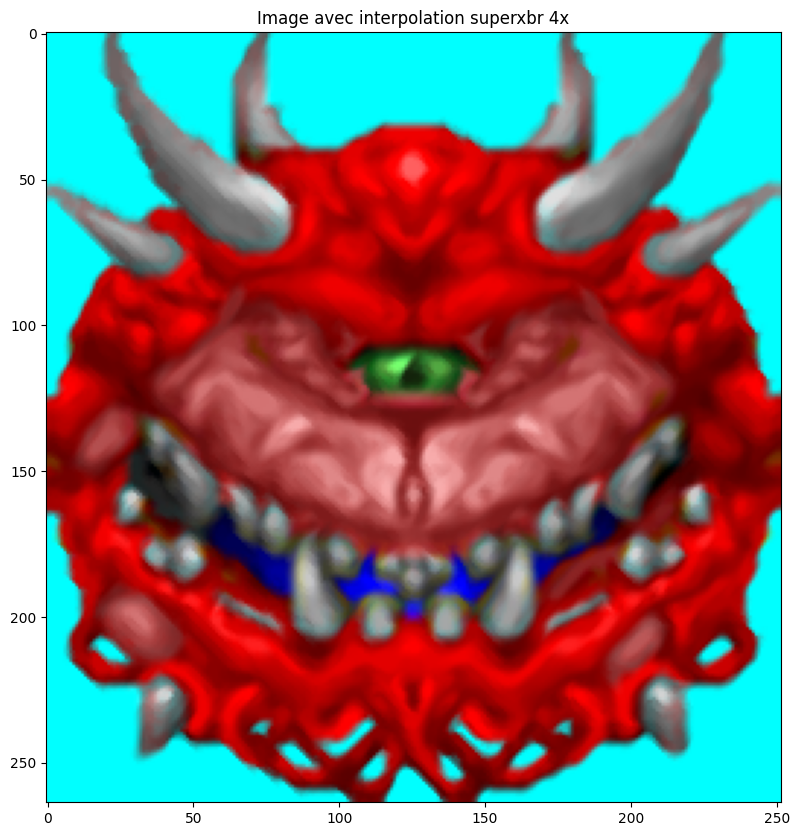

In [184]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    caco_superxbr4 = superxbr.scale(caco_superxbr2)
array4x.append(caco_superxbr4)
affichage(caco_superxbr4,"jet",titre="Image avec interpolation superxbr 4x")

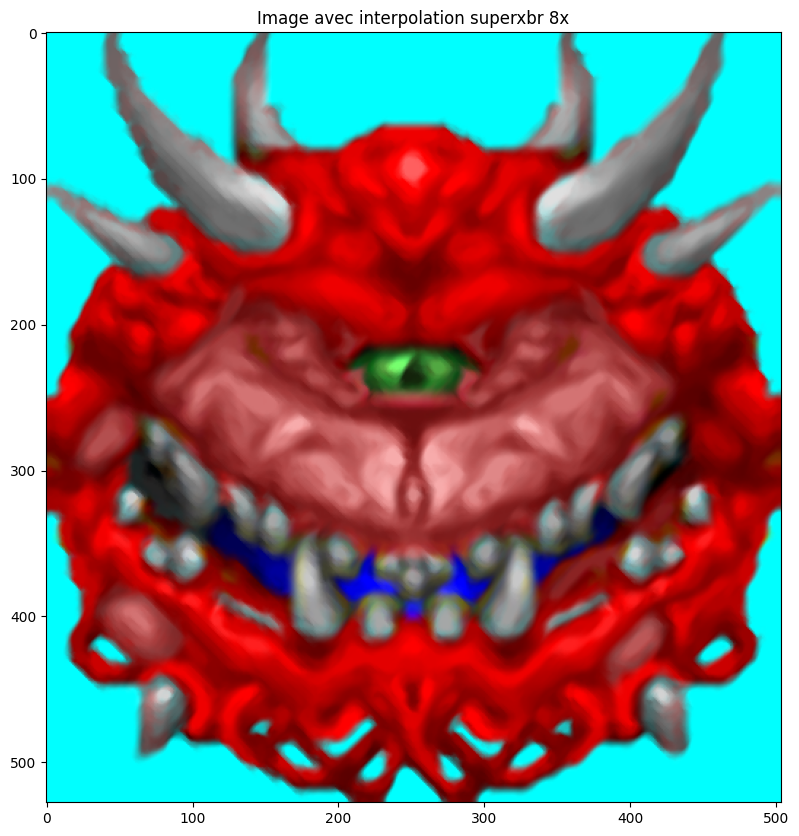

In [185]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    caco_superxbr8 = superxbr.scale(caco_superxbr4)
array8x.append(caco_superxbr8)
affichage(caco_superxbr8,"jet",titre="Image avec interpolation superxbr 8x")

## Galerie

Pas de commentaires, il s'agit seulement d'une synthèse des transformations opérées

### Comparaison des 2x

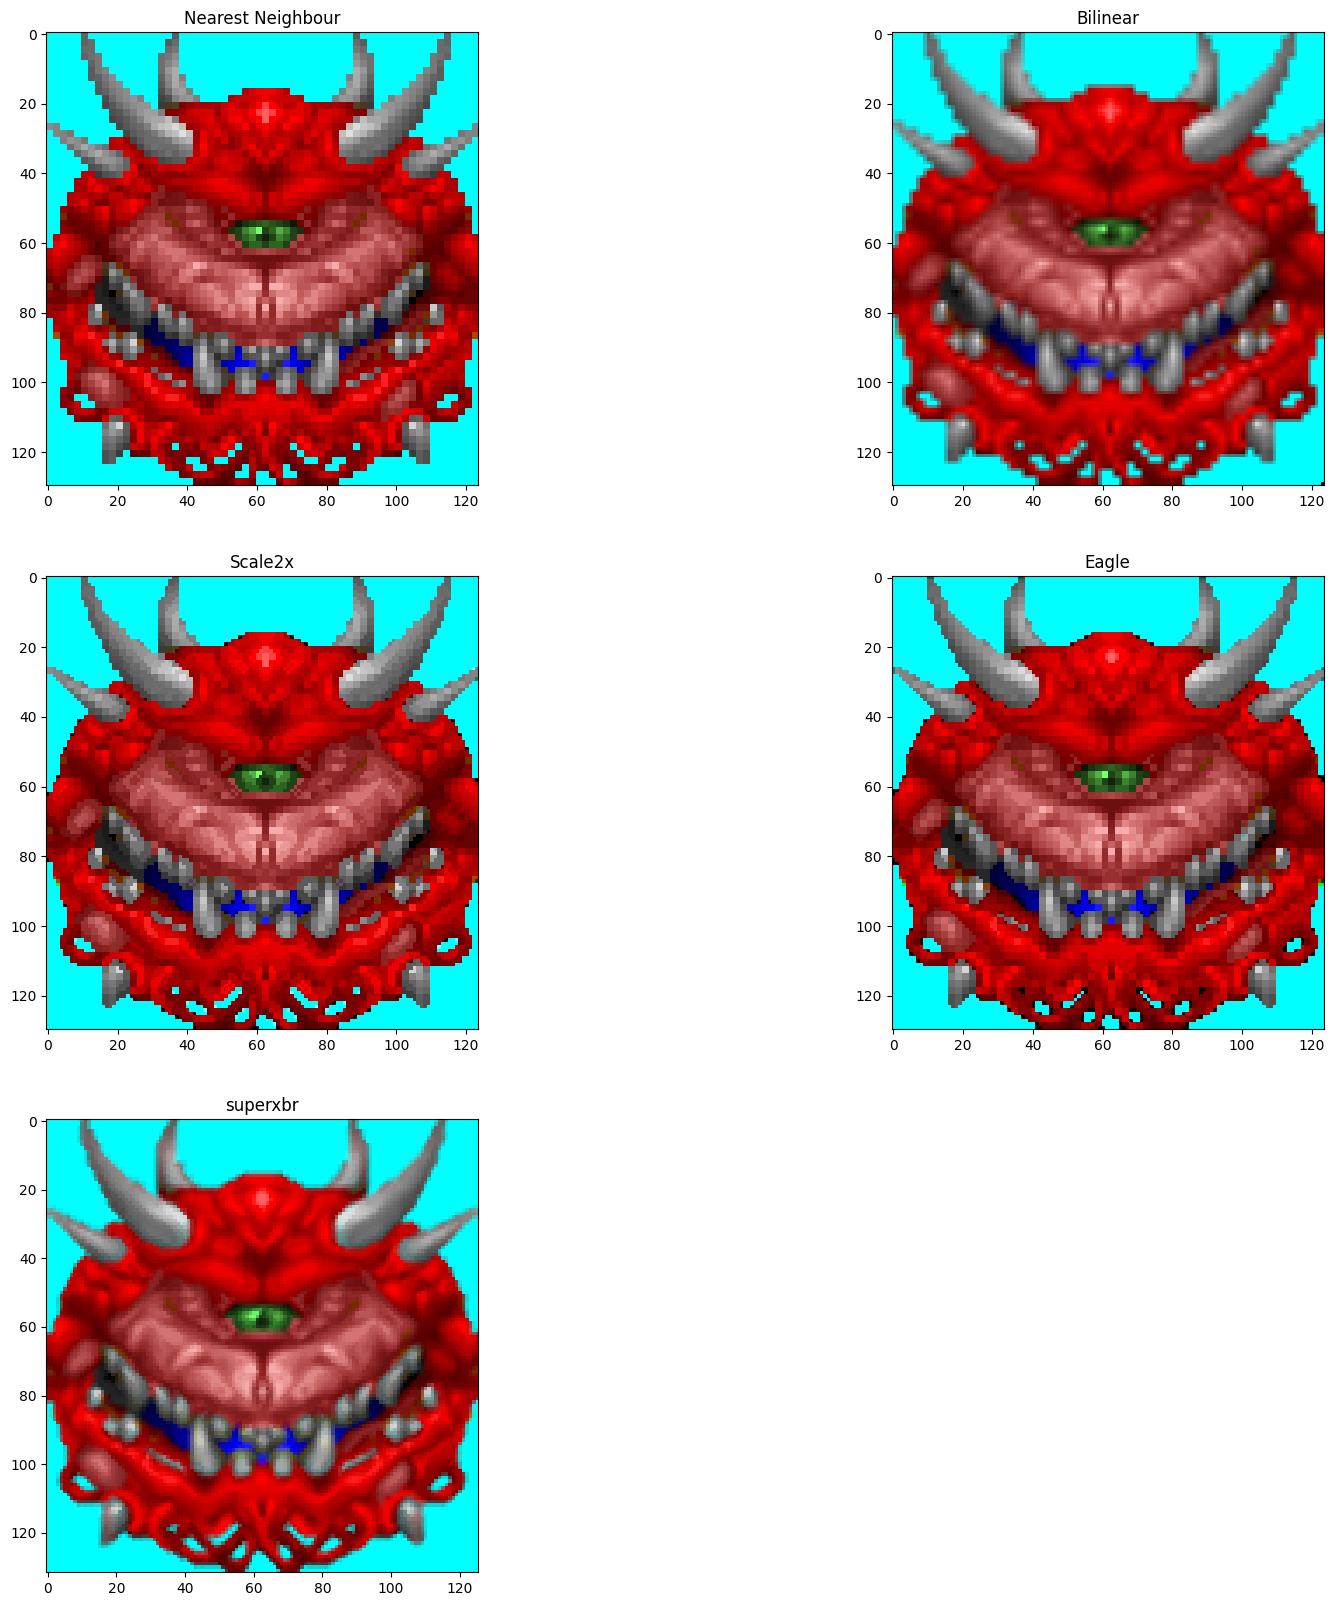

In [186]:
taille = 20
labels = ["Nearest Neighbour","Bilinear","Scale2x","Eagle","superxbr"]
plt.figure(figsize=[taille,taille])
for i in range(1,len(array2x)+1):
    plt.subplot(len(array2x)//2 +1,2,i)
    plt.title(labels[i-1])
    plt.imshow(array2x[i-1])

### Comparaison des 4x

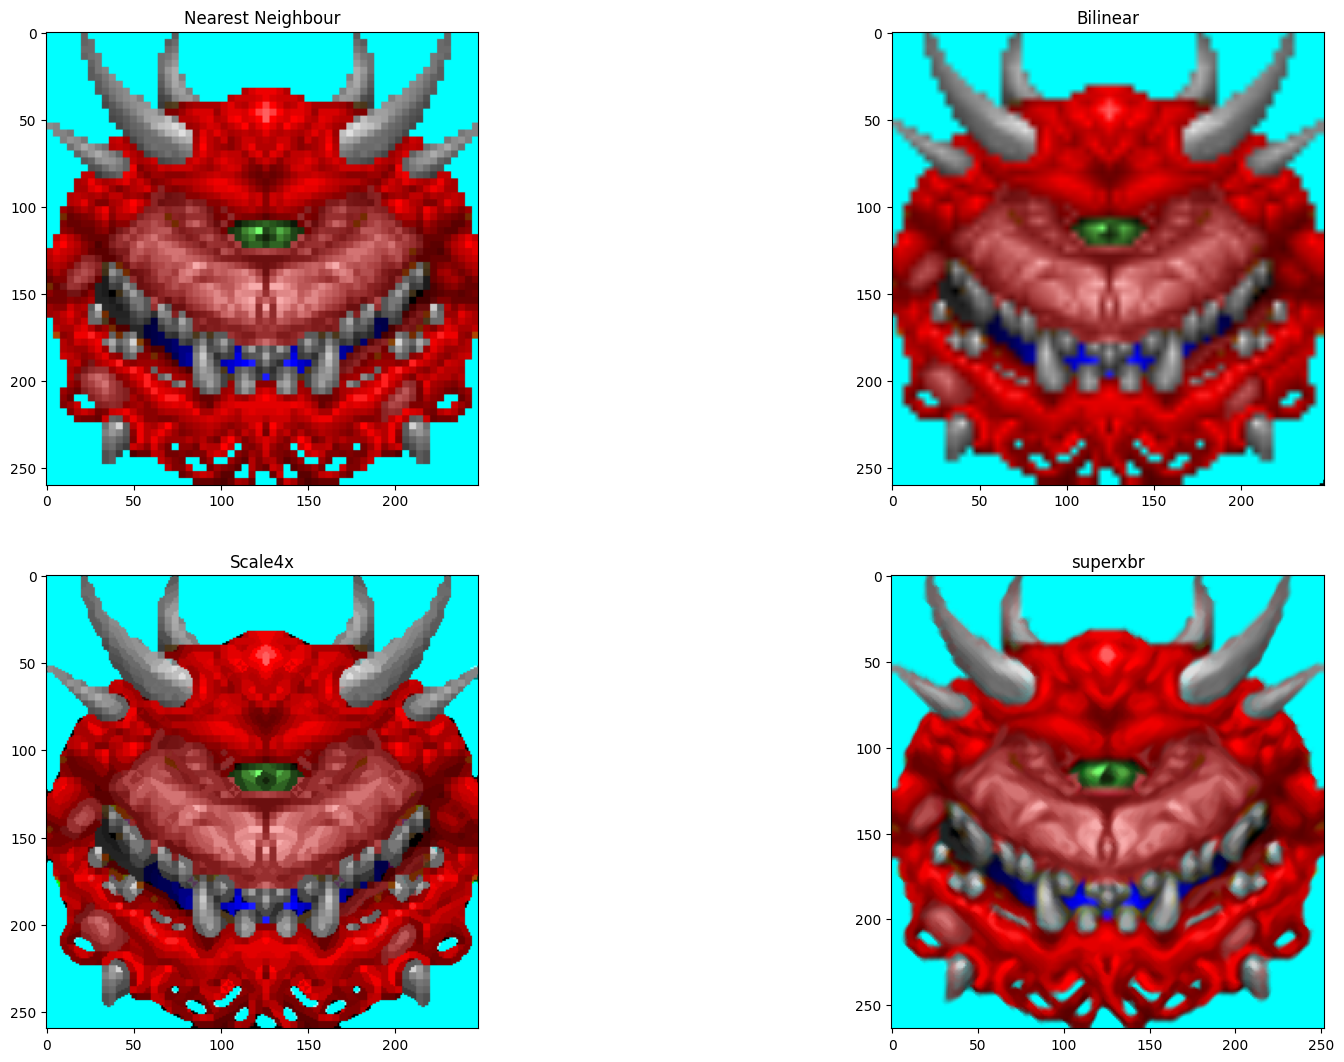

In [187]:
taille = 20
labels2 = ["Nearest Neighbour","Bilinear","Scale4x","superxbr"]
plt.figure(figsize=[taille,taille])
for i in range(1,len(array4x)+1):
    plt.subplot(len(array4x)//2 +1,2,i)
    plt.title(labels2[i-1])
    plt.imshow(array4x[i-1])

### Comparaison des 8x

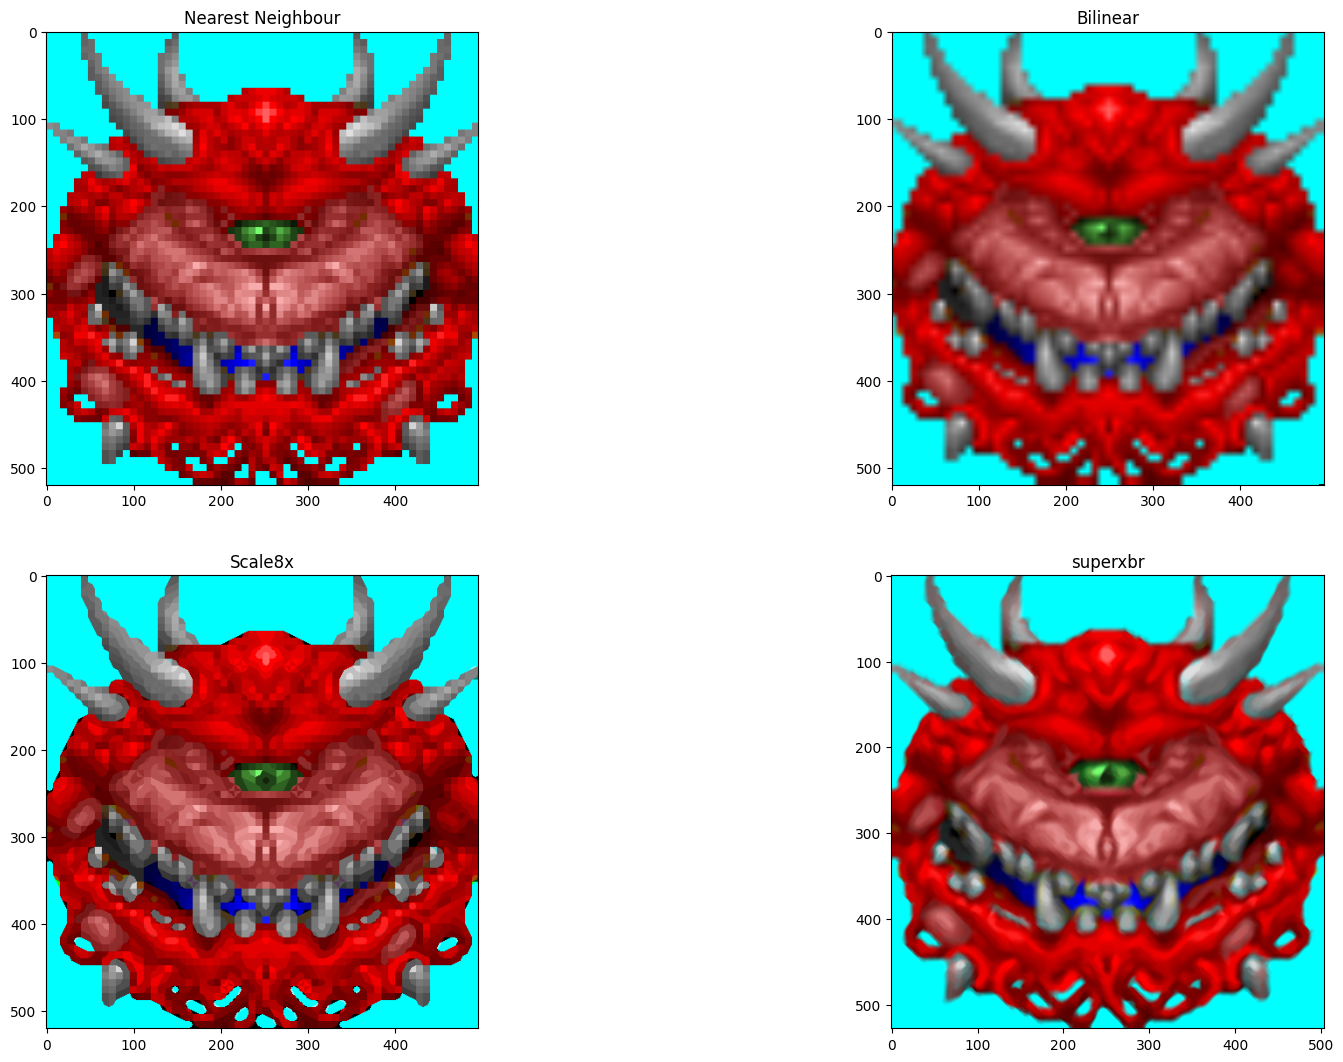

In [188]:
taille = 20
labels3 = ["Nearest Neighbour","Bilinear","Scale8x","superxbr"]
plt.figure(figsize=[taille,taille])
for i in range(1,len(array8x)+1):
    plt.subplot(len(array8x)//2 +1,2,i)
    plt.title(labels3[i-1])
    plt.imshow(array8x[i-1])